<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [2]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

## Detect available device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Definition of an activation function and its derivatives

In [4]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [5]:
class WaveFunction(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(WaveFunction, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1]


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape) #[None] * self.N #
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N).to(device)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian

In [79]:
def A(x_):
  p = torch.ones(x_.shape[0]).to(device)

  for i in range(x_.shape[1]):
    p *= (x_[:,i] - 1/2)**2-1/4

  return p
  
def Ax(x_):
  p = torch.ones(x_.shape).to(device)

  for i in range(x_.shape[1]):
    p[:, i] = A(x_) * 2 * (x_[:,i] - 1/2) / ((x_[:,i] - 1/2)**2-1/4)

  return p
  
def Axx(x_):
  return 2 * A(x_) * torch.sum( ((x_ - 1/2)**2 - 1/4)**(-1), axis=1 )

def train_loop(N, N_batch, M, wf, optimizer):#, eigval):
  """
  N --- a size of the input vector, its dimension
  M --- total number of iterations
  """

  loss_fn = nn.L1Loss()
  
  for i in range(M):
    x_test = torch.rand((N_batch, N)).to(device)

    phi_test = wf(x_test).reshape(len(x_test)).to(device)
    phix_test = wf.grad(x_test).to(device)
    phixx_test = wf.laplac(x_test).reshape(len(x_test)).to(device)

    # если задавать нужное значение энергии, то всё получается
    # I = torch.mean( (phixx_test * A(x_test) \
    #                  + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
    #                  + Axx(x_test) * phi_test \
    #                  + eigval*phi_test*A(x_test))**2 )

    I = torch.mean( (-(phixx_test * A(x_test) \
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
                     + Axx(x_test) * phi_test) \
                     - torch.mean(-(phixx_test * A(x_test)\
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
                     + Axx(x_test) * phi_test) * phi_test * A(x_test))\
        / torch.mean((phi_test * A(x_test))**2) *phi_test * A(x_test))**2 )
    
    # I = torch.mean(-(phixx_test * A(x_test)\
    #                  + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
    #                  + Axx(x_test) * phi_test) * phi_test * A(x_test))\
    #     / torch.mean((phi_test * A(x_test))**2)

    # Compute loss
    loss = loss_fn(I, torch.tensor(0.0).to(device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if np.isnan(loss.item()):
      print(f'{i:} LOSS FUNCTION IS NAN')
      break

    if (i+1) % 100 == 0:
      E = torch.mean(-(phixx_test * A(x_test)\
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
                     + Axx(x_test) * phi_test) * phi_test * A(x_test))\
        / torch.mean((phi_test * A(x_test))**2)
      print(f"Residual: {loss.item():>0.5E}, Energy: {E:>0.5f}  [{i+1:>5d} / {M:>5d}]")

# 1D

In [29]:
def plot_compar_1d(wf):
  x = torch.linspace(1e-2,1-1e-2,100).reshape((-1, N)).to(device)
  y = wf(x) * A(x).reshape((-1,N))

  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()

  plt.plot(x, (y/y.mean())**2,
           label='What we get')
  
  plt.plot(x, (np.sin(x*np.pi)/np.sin(x*np.pi).mean())**2,
           label='What we should get')

  plt.legend()
  plt.xlim(0,1)
  plt.ylim(0.0,None)

  plt.show()

## Initialization of our wavefunction

In [36]:
N = 1  # size of the input vector
wf = WaveFunction(N, [10]*2).to(device) ## число внутренних слоёв должно быть той же четности, что и номер состояния

## Its training


 Epoch 1
-------------------------------
Residual: 2.74109E-04, Energy: 9.93340  [  100 /  1000]
Residual: 1.02854E-05, Energy: 9.91327  [  200 /  1000]
Residual: 2.22914E-05, Energy: 10.04026  [  300 /  1000]
Residual: 3.38806E-05, Energy: 9.88871  [  400 /  1000]
Residual: 8.42750E-06, Energy: 9.85673  [  500 /  1000]
Residual: 2.04712E-05, Energy: 9.89863  [  600 /  1000]
Residual: 1.35179E-05, Energy: 9.81255  [  700 /  1000]
Residual: 1.08293E-05, Energy: 9.84588  [  800 /  1000]
Residual: 1.36234E-05, Energy: 9.88781  [  900 /  1000]
Residual: 4.11977E-06, Energy: 9.82871  [ 1000 /  1000]


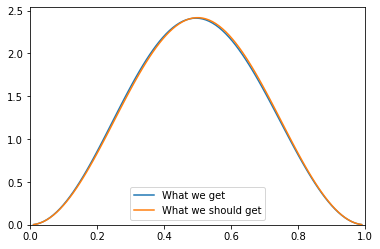


 Epoch 2
-------------------------------
Residual: 4.85810E-06, Energy: 9.93984  [  100 /  1000]
Residual: 4.57109E-06, Energy: 9.83536  [  200 /  1000]
Residual: 2.80015E-06, Energy: 9.84723  [  300 /  1000]
Residual: 2.56062E-06, Energy: 9.88352  [  400 /  1000]
Residual: 9.44084E-06, Energy: 9.83056  [  500 /  1000]
Residual: 5.38281E-06, Energy: 9.97515  [  600 /  1000]
Residual: 1.55999E-06, Energy: 9.91279  [  700 /  1000]
Residual: 3.23314E-06, Energy: 9.86659  [  800 /  1000]
Residual: 1.68153E-06, Energy: 9.82458  [  900 /  1000]
Residual: 1.11448E-06, Energy: 9.93497  [ 1000 /  1000]


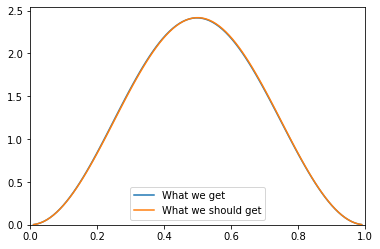


 Epoch 3
-------------------------------
Residual: 3.38006E-06, Energy: 9.84147  [  100 /  1000]
Residual: 3.25591E-07, Energy: 9.85841  [  200 /  1000]
Residual: 1.00034E-06, Energy: 9.91154  [  300 /  1000]
Residual: 3.01370E-07, Energy: 9.89533  [  400 /  1000]
Residual: 8.65646E-07, Energy: 9.88849  [  500 /  1000]
Residual: 1.78835E-07, Energy: 9.85201  [  600 /  1000]
Residual: 6.35208E-07, Energy: 9.85104  [  700 /  1000]
Residual: 6.41176E-07, Energy: 9.86412  [  800 /  1000]
Residual: 4.61879E-07, Energy: 9.87374  [  900 /  1000]
Residual: 3.25350E-07, Energy: 9.87065  [ 1000 /  1000]


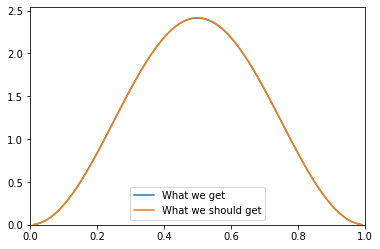


 Epoch 4
-------------------------------
Residual: 1.36737E-07, Energy: 9.86141  [  100 /  1000]
Residual: 1.80170E-07, Energy: 9.86458  [  200 /  1000]
Residual: 2.43838E-07, Energy: 9.85510  [  300 /  1000]
Residual: 1.10843E-07, Energy: 9.86257  [  400 /  1000]
Residual: 7.25052E-08, Energy: 9.86484  [  500 /  1000]
Residual: 7.27798E-08, Energy: 9.85425  [  600 /  1000]
Residual: 5.11047E-07, Energy: 9.88544  [  700 /  1000]
Residual: 1.66295E-07, Energy: 9.86337  [  800 /  1000]
Residual: 5.94452E-08, Energy: 9.90341  [  900 /  1000]
Residual: 1.14049E-07, Energy: 9.87168  [ 1000 /  1000]


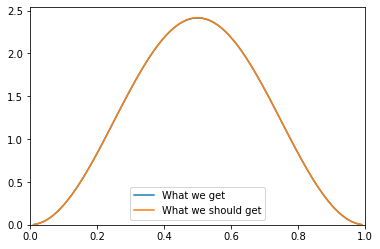


 Epoch 5
-------------------------------
Residual: 5.25279E-07, Energy: 9.88233  [  100 /  1000]
Residual: 1.82357E-07, Energy: 9.87582  [  200 /  1000]
Residual: 2.14134E-07, Energy: 9.87850  [  300 /  1000]
Residual: 1.25165E-06, Energy: 9.85958  [  400 /  1000]
Residual: 4.15900E-07, Energy: 9.87628  [  500 /  1000]
Residual: 5.07222E-07, Energy: 9.89178  [  600 /  1000]
Residual: 4.19816E-07, Energy: 9.86334  [  700 /  1000]
Residual: 8.73176E-08, Energy: 9.86032  [  800 /  1000]
Residual: 1.79386E-07, Energy: 9.89381  [  900 /  1000]
Residual: 1.92889E-07, Energy: 9.87147  [ 1000 /  1000]


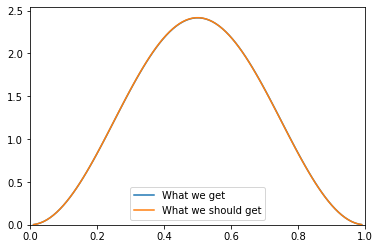


 Epoch 6
-------------------------------
Residual: 7.87935E-08, Energy: 9.86073  [  100 /  1000]
Residual: 1.54315E-07, Energy: 9.89855  [  200 /  1000]
Residual: 2.37304E-07, Energy: 9.86404  [  300 /  1000]
Residual: 1.25846E-07, Energy: 9.86402  [  400 /  1000]
Residual: 4.72190E-07, Energy: 9.86298  [  500 /  1000]
Residual: 5.81353E-08, Energy: 9.87954  [  600 /  1000]
Residual: 1.15596E-07, Energy: 9.87470  [  700 /  1000]
Residual: 1.67500E-07, Energy: 9.88015  [  800 /  1000]
Residual: 1.46082E-07, Energy: 9.89058  [  900 /  1000]
Residual: 1.36789E-07, Energy: 9.88477  [ 1000 /  1000]


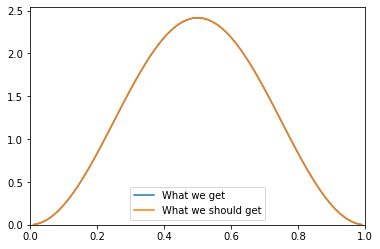


 Epoch 7
-------------------------------
Residual: 1.08228E-07, Energy: 9.87805  [  100 /  1000]
Residual: 1.83937E-07, Energy: 9.87492  [  200 /  1000]
Residual: 8.10659E-08, Energy: 9.87481  [  300 /  1000]
Residual: 6.79551E-07, Energy: 9.87723  [  400 /  1000]
Residual: 1.08388E-07, Energy: 9.85606  [  500 /  1000]
Residual: 1.56178E-07, Energy: 9.85834  [  600 /  1000]
Residual: 1.22256E-07, Energy: 9.86883  [  700 /  1000]
Residual: 1.48084E-07, Energy: 9.86555  [  800 /  1000]
Residual: 3.15766E-07, Energy: 9.87957  [  900 /  1000]
Residual: 3.46526E-08, Energy: 9.86617  [ 1000 /  1000]


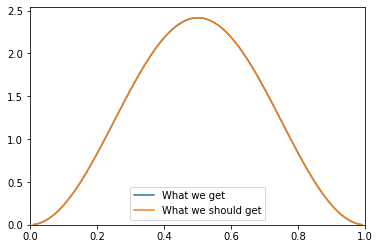


 Epoch 8
-------------------------------
Residual: 2.19027E-07, Energy: 9.85978  [  100 /  1000]
Residual: 5.14548E-07, Energy: 9.88042  [  200 /  1000]
Residual: 4.73982E-08, Energy: 9.87164  [  300 /  1000]
Residual: 2.42625E-07, Energy: 9.87101  [  400 /  1000]
Residual: 4.64818E-06, Energy: 9.85806  [  500 /  1000]
Residual: 2.50396E-08, Energy: 9.86848  [  600 /  1000]
Residual: 6.56605E-08, Energy: 9.88074  [  700 /  1000]
Residual: 7.29446E-08, Energy: 9.88129  [  800 /  1000]
Residual: 5.87812E-08, Energy: 9.86701  [  900 /  1000]
Residual: 5.06688E-07, Energy: 9.86955  [ 1000 /  1000]


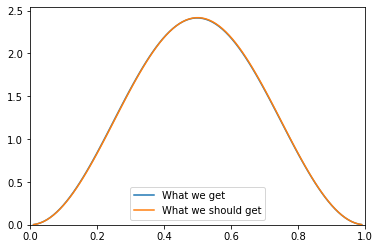


 Epoch 9
-------------------------------
Residual: 1.56493E-07, Energy: 9.87319  [  100 /  1000]
Residual: 1.07915E-07, Energy: 9.86500  [  200 /  1000]
Residual: 6.19039E-07, Energy: 9.86166  [  300 /  1000]
Residual: 5.70110E-08, Energy: 9.87345  [  400 /  1000]
Residual: 5.47095E-09, Energy: 9.86506  [  500 /  1000]
Residual: 4.29717E-08, Energy: 9.87234  [  600 /  1000]
Residual: 3.13411E-07, Energy: 9.87973  [  700 /  1000]
Residual: 6.84602E-07, Energy: 9.86016  [  800 /  1000]
Residual: 2.35181E-08, Energy: 9.86697  [  900 /  1000]
Residual: 1.85775E-06, Energy: 9.82865  [ 1000 /  1000]


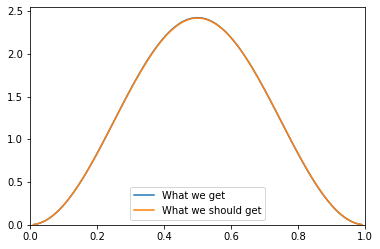


 Epoch 10
-------------------------------
Residual: 6.04961E-08, Energy: 9.87577  [  100 /  1000]
Residual: 1.68801E-08, Energy: 9.87241  [  200 /  1000]
Residual: 1.15555E-07, Energy: 9.86111  [  300 /  1000]
Residual: 7.84825E-08, Energy: 9.87665  [  400 /  1000]
Residual: 9.64638E-07, Energy: 9.86728  [  500 /  1000]
Residual: 6.82158E-08, Energy: 9.86706  [  600 /  1000]
Residual: 1.12186E-07, Energy: 9.87813  [  700 /  1000]
Residual: 1.32121E-07, Energy: 9.86058  [  800 /  1000]
Residual: 1.04267E-06, Energy: 9.87947  [  900 /  1000]
Residual: 4.13270E-07, Energy: 9.88898  [ 1000 /  1000]


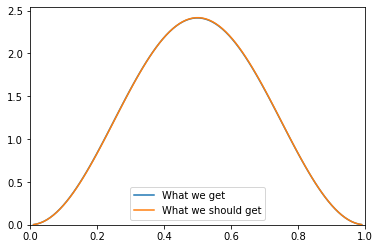


 Epoch 11
-------------------------------
Residual: 2.10883E-07, Energy: 9.86169  [  100 /  1000]
Residual: 1.11266E-06, Energy: 9.86453  [  200 /  1000]
Residual: 2.11680E-07, Energy: 9.86994  [  300 /  1000]
Residual: 1.08260E-07, Energy: 9.86638  [  400 /  1000]
Residual: 1.03095E-07, Energy: 9.88235  [  500 /  1000]
Residual: 1.74559E-07, Energy: 9.86403  [  600 /  1000]
Residual: 1.04272E-07, Energy: 9.85798  [  700 /  1000]
Residual: 2.06615E-07, Energy: 9.86538  [  800 /  1000]
Residual: 8.17891E-08, Energy: 9.87385  [  900 /  1000]
Residual: 1.53414E-07, Energy: 9.88150  [ 1000 /  1000]


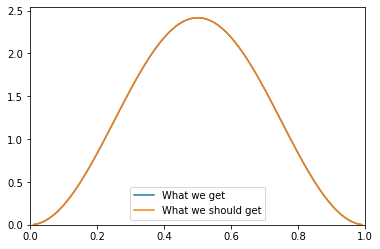


 Epoch 12
-------------------------------
Residual: 1.62725E-08, Energy: 9.86664  [  100 /  1000]
Residual: 2.24150E-07, Energy: 9.85845  [  200 /  1000]
Residual: 5.73887E-07, Energy: 9.86846  [  300 /  1000]
Residual: 1.84528E-08, Energy: 9.87037  [  400 /  1000]
Residual: 7.29801E-08, Energy: 9.86631  [  500 /  1000]
Residual: 1.28487E-07, Energy: 9.87101  [  600 /  1000]
Residual: 3.49497E-07, Energy: 9.86732  [  700 /  1000]
Residual: 1.05406E-07, Energy: 9.86912  [  800 /  1000]
Residual: 1.67577E-08, Energy: 9.86896  [  900 /  1000]
Residual: 4.78284E-07, Energy: 9.90504  [ 1000 /  1000]


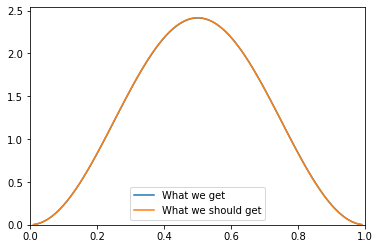


 Epoch 13
-------------------------------
Residual: 1.14098E-07, Energy: 9.86692  [  100 /  1000]
Residual: 8.07296E-09, Energy: 9.86860  [  200 /  1000]
Residual: 1.78269E-08, Energy: 9.86499  [  300 /  1000]
Residual: 9.25202E-08, Energy: 9.85957  [  400 /  1000]
Residual: 1.83176E-07, Energy: 9.86985  [  500 /  1000]
Residual: 1.88186E-07, Energy: 9.89244  [  600 /  1000]
Residual: 1.31035E-07, Energy: 9.86683  [  700 /  1000]
Residual: 2.79178E-08, Energy: 9.86920  [  800 /  1000]
Residual: 1.63517E-07, Energy: 9.87262  [  900 /  1000]
Residual: 1.33846E-07, Energy: 9.87036  [ 1000 /  1000]


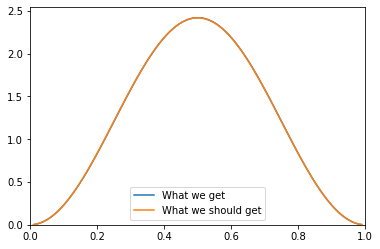


 Epoch 14
-------------------------------
Residual: 9.48254E-07, Energy: 9.87223  [  100 /  1000]
Residual: 1.67143E-09, Energy: 9.87494  [  200 /  1000]
Residual: 7.47576E-09, Energy: 9.86864  [  300 /  1000]
Residual: 1.02293E-07, Energy: 9.86965  [  400 /  1000]
Residual: 8.66099E-09, Energy: 9.86987  [  500 /  1000]
Residual: 1.78488E-08, Energy: 9.87023  [  600 /  1000]
Residual: 1.98965E-08, Energy: 9.86759  [  700 /  1000]
Residual: 5.02017E-08, Energy: 9.86753  [  800 /  1000]
Residual: 1.05424E-08, Energy: 9.86887  [  900 /  1000]
Residual: 7.88528E-10, Energy: 9.86325  [ 1000 /  1000]


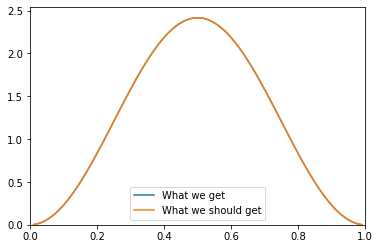


 Epoch 15
-------------------------------
Residual: 3.41804E-08, Energy: 9.86994  [  100 /  1000]
Residual: 4.87077E-07, Energy: 9.86335  [  200 /  1000]
Residual: 2.13735E-08, Energy: 9.87347  [  300 /  1000]
Residual: 4.86142E-07, Energy: 9.85253  [  400 /  1000]
Residual: 2.70527E-08, Energy: 9.87137  [  500 /  1000]
Residual: 1.82308E-07, Energy: 9.86661  [  600 /  1000]
Residual: 1.42337E-07, Energy: 9.87553  [  700 /  1000]
Residual: 2.73325E-07, Energy: 9.88167  [  800 /  1000]
Residual: 7.96146E-07, Energy: 9.84416  [  900 /  1000]
Residual: 8.60688E-08, Energy: 9.87764  [ 1000 /  1000]


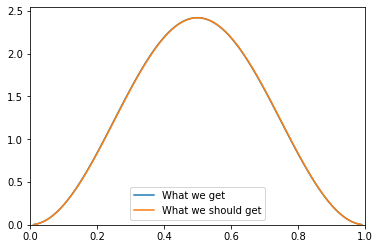


 Epoch 16
-------------------------------
Residual: 2.55538E-07, Energy: 9.87979  [  100 /  1000]
Residual: 1.71442E-07, Energy: 9.87142  [  200 /  1000]
Residual: 1.94803E-08, Energy: 9.86542  [  300 /  1000]
Residual: 2.54467E-08, Energy: 9.86939  [  400 /  1000]
Residual: 7.52319E-09, Energy: 9.86736  [  500 /  1000]
Residual: 5.42834E-09, Energy: 9.87191  [  600 /  1000]
Residual: 2.05339E-08, Energy: 9.86515  [  700 /  1000]
Residual: 1.48291E-08, Energy: 9.86631  [  800 /  1000]
Residual: 4.73268E-08, Energy: 9.87270  [  900 /  1000]
Residual: 3.20673E-09, Energy: 9.86874  [ 1000 /  1000]


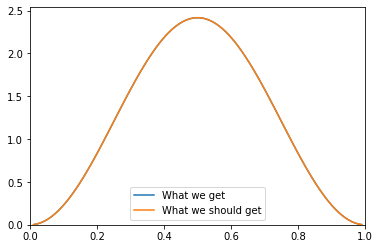


 Epoch 17
-------------------------------
Residual: 4.94476E-08, Energy: 9.86881  [  100 /  1000]
Residual: 4.43763E-08, Energy: 9.86313  [  200 /  1000]
Residual: 2.39264E-08, Energy: 9.86877  [  300 /  1000]
Residual: 3.09937E-08, Energy: 9.87053  [  400 /  1000]
Residual: 1.95650E-08, Energy: 9.87351  [  500 /  1000]
Residual: 3.31827E-08, Energy: 9.86889  [  600 /  1000]
Residual: 1.24525E-07, Energy: 9.86647  [  700 /  1000]
Residual: 3.98320E-08, Energy: 9.86783  [  800 /  1000]
Residual: 4.04583E-08, Energy: 9.85827  [  900 /  1000]
Residual: 6.30332E-08, Energy: 9.86169  [ 1000 /  1000]


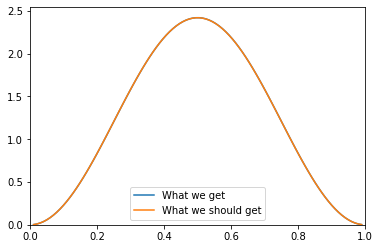


 Epoch 18
-------------------------------
Residual: 8.57897E-08, Energy: 9.86824  [  100 /  1000]
Residual: 1.67892E-08, Energy: 9.86381  [  200 /  1000]
Residual: 1.31202E-08, Energy: 9.87430  [  300 /  1000]
Residual: 7.35793E-09, Energy: 9.86948  [  400 /  1000]
Residual: 9.09805E-08, Energy: 9.87387  [  500 /  1000]
Residual: 3.91651E-08, Energy: 9.86689  [  600 /  1000]
Residual: 1.23454E-06, Energy: 9.86080  [  700 /  1000]
Residual: 3.58494E-09, Energy: 9.86478  [  800 /  1000]
Residual: 5.51489E-09, Energy: 9.86545  [  900 /  1000]
Residual: 1.37410E-08, Energy: 9.87758  [ 1000 /  1000]


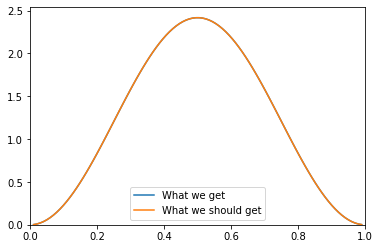


 Epoch 19
-------------------------------
Residual: 6.50627E-08, Energy: 9.85544  [  100 /  1000]
Residual: 1.66103E-07, Energy: 9.88480  [  200 /  1000]
Residual: 3.09031E-08, Energy: 9.87254  [  300 /  1000]
Residual: 1.74091E-08, Energy: 9.87087  [  400 /  1000]
Residual: 1.35367E-08, Energy: 9.87160  [  500 /  1000]
Residual: 6.32618E-08, Energy: 9.86308  [  600 /  1000]
Residual: 3.03699E-09, Energy: 9.86969  [  700 /  1000]
Residual: 5.00262E-09, Energy: 9.87383  [  800 /  1000]
Residual: 1.12338E-07, Energy: 9.85606  [  900 /  1000]
Residual: 5.81814E-08, Energy: 9.87177  [ 1000 /  1000]


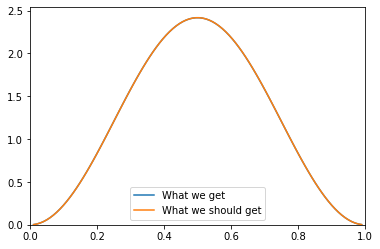


 Epoch 20
-------------------------------
Residual: 1.42177E-08, Energy: 9.87116  [  100 /  1000]
Residual: 1.52509E-08, Energy: 9.87369  [  200 /  1000]
Residual: 3.98894E-08, Energy: 9.87440  [  300 /  1000]
Residual: 4.61347E-08, Energy: 9.86802  [  400 /  1000]
Residual: 6.46423E-08, Energy: 9.87385  [  500 /  1000]
Residual: 2.30726E-07, Energy: 9.86423  [  600 /  1000]
Residual: 3.07180E-08, Energy: 9.87252  [  700 /  1000]
Residual: 1.63496E-07, Energy: 9.86252  [  800 /  1000]
Residual: 1.90660E-08, Energy: 9.87049  [  900 /  1000]
Residual: 8.33553E-08, Energy: 9.87093  [ 1000 /  1000]


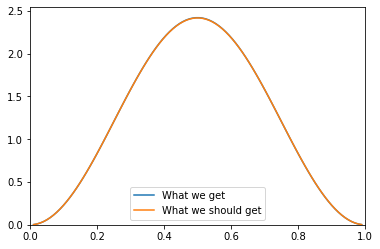


 Epoch 21
-------------------------------
Residual: 2.05773E-08, Energy: 9.87126  [  100 /  1000]
Residual: 3.56824E-09, Energy: 9.86858  [  200 /  1000]
Residual: 1.20991E-08, Energy: 9.86868  [  300 /  1000]
Residual: 1.23786E-08, Energy: 9.86953  [  400 /  1000]
Residual: 6.39560E-08, Energy: 9.86737  [  500 /  1000]
Residual: 3.28592E-08, Energy: 9.87201  [  600 /  1000]
Residual: 2.53542E-07, Energy: 9.87504  [  700 /  1000]
Residual: 2.13525E-07, Energy: 9.87112  [  800 /  1000]
Residual: 1.22560E-08, Energy: 9.87024  [  900 /  1000]
Residual: 1.43925E-07, Energy: 9.86036  [ 1000 /  1000]


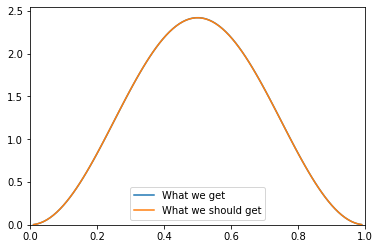


 Epoch 22
-------------------------------
Residual: 2.33376E-08, Energy: 9.86573  [  100 /  1000]
Residual: 1.10738E-08, Energy: 9.86938  [  200 /  1000]
Residual: 1.93256E-08, Energy: 9.87078  [  300 /  1000]
Residual: 1.34845E-08, Energy: 9.86683  [  400 /  1000]
Residual: 4.56903E-08, Energy: 9.86943  [  500 /  1000]
Residual: 6.28434E-09, Energy: 9.87089  [  600 /  1000]
Residual: 2.30667E-07, Energy: 9.86595  [  700 /  1000]
Residual: 6.73380E-08, Energy: 9.86314  [  800 /  1000]
Residual: 2.32203E-08, Energy: 9.86248  [  900 /  1000]
Residual: 3.18287E-07, Energy: 9.86656  [ 1000 /  1000]


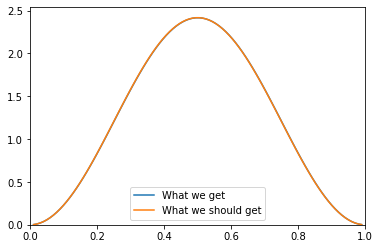


 Epoch 23
-------------------------------
Residual: 9.66857E-09, Energy: 9.86982  [  100 /  1000]
Residual: 9.86233E-09, Energy: 9.86815  [  200 /  1000]
Residual: 1.96951E-08, Energy: 9.86353  [  300 /  1000]
Residual: 1.54330E-08, Energy: 9.87136  [  400 /  1000]
Residual: 4.14807E-09, Energy: 9.86582  [  500 /  1000]
Residual: 3.44233E-08, Energy: 9.86752  [  600 /  1000]
Residual: 7.14540E-08, Energy: 9.87349  [  700 /  1000]
Residual: 1.93543E-08, Energy: 9.86933  [  800 /  1000]
Residual: 1.13118E-08, Energy: 9.86978  [  900 /  1000]
Residual: 4.06510E-08, Energy: 9.87236  [ 1000 /  1000]


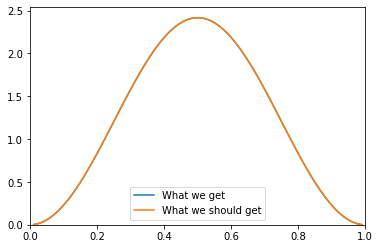


 Epoch 24
-------------------------------
Residual: 7.90396E-09, Energy: 9.86958  [  100 /  1000]
Residual: 1.15670E-08, Energy: 9.86511  [  200 /  1000]
Residual: 1.32313E-08, Energy: 9.86529  [  300 /  1000]
Residual: 1.56581E-08, Energy: 9.87140  [  400 /  1000]
Residual: 2.65737E-08, Energy: 9.86745  [  500 /  1000]
Residual: 1.48476E-08, Energy: 9.86618  [  600 /  1000]
Residual: 6.92551E-08, Energy: 9.86856  [  700 /  1000]
Residual: 6.47062E-09, Energy: 9.86995  [  800 /  1000]
Residual: 6.71106E-07, Energy: 9.86156  [  900 /  1000]
Residual: 5.48224E-08, Energy: 9.87175  [ 1000 /  1000]


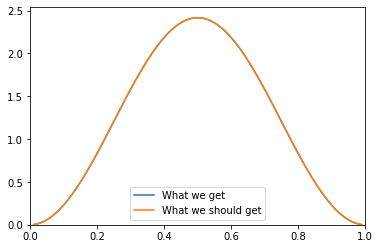


 Epoch 25
-------------------------------
Residual: 8.22043E-09, Energy: 9.87069  [  100 /  1000]
Residual: 4.16355E-08, Energy: 9.87082  [  200 /  1000]
Residual: 7.66899E-09, Energy: 9.87695  [  300 /  1000]
Residual: 4.44529E-08, Energy: 9.87364  [  400 /  1000]
Residual: 6.35499E-08, Energy: 9.87326  [  500 /  1000]
Residual: 9.14425E-09, Energy: 9.87218  [  600 /  1000]
Residual: 6.51152E-08, Energy: 9.87081  [  700 /  1000]
Residual: 1.23895E-08, Energy: 9.86975  [  800 /  1000]
Residual: 1.45454E-08, Energy: 9.87003  [  900 /  1000]
Residual: 6.87975E-09, Energy: 9.86940  [ 1000 /  1000]


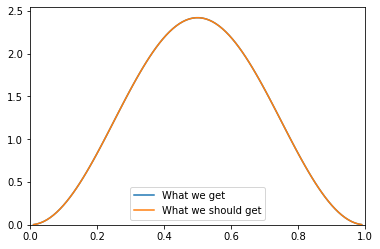

In [37]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 25
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)#, np.pi**2)
  scheduler.step()
  plot_compar_1d(wf)

# 2D

In [38]:
def plot_compare_2d(wf):
  n = 100 # number of points over one dimension
  x = np.linspace(0,1,n)
  xs, ys = np.meshgrid(x,x, sparse=True)
  
  X = np.array([[xs[0,i], ys[j,0]] for i in range(100) for j in range(100)])
  X = torch.tensor(X).to(device)

  phi = wf(X.float()).reshape(len(X)).to(device) \
        * A(X.float()).reshape(len(X)).to(device)
  sin = torch.sin(np.pi*X[:,0].float())*torch.sin(np.pi*X[:,1].float())

  phi = phi.reshape(100,100).cpu().detach().numpy()
  sin = sin.reshape(100,100).cpu().detach().numpy()

  fig, ax = plt.subplots(1, 2, figsize=(14,5))

  pcm0 = ax[0].contourf(x, x, (phi/phi.mean())**2)

  fig.colorbar(pcm0, ax=ax[0], extend='max')

  pcm1 = ax[1].contourf(x, x, (sin/sin.mean())**2)

  fig.colorbar(pcm1, ax=ax[1], extend='max')

  ax[0].set_xlabel(r'$x_1$')
  ax[0].set_ylabel(r'$x_2$')

  ax[1].set_xlabel(r'$x_1$')
  ax[1].set_ylabel(r'$x_2$')

  ax[0].set_title(r'What $|\psi|^2$ we get')
  ax[1].set_title(r'What $|\psi|^2$ we should get')

  plt.show()

In [43]:
N = 2
wf = WaveFunction(N, [10**N]*3).to(device) 


 Epoch 1
-------------------------------
Residual: 1.71739E-07, Energy: 19.74167  [  100 /  1000]
Residual: 9.69896E-08, Energy: 19.71354  [  200 /  1000]
Residual: 5.07770E-08, Energy: 19.77686  [  300 /  1000]
Residual: 2.54083E-08, Energy: 19.67511  [  400 /  1000]
Residual: 2.02960E-08, Energy: 19.80929  [  500 /  1000]
Residual: 1.49733E-08, Energy: 19.77270  [  600 /  1000]
Residual: 1.35413E-08, Energy: 19.72877  [  700 /  1000]
Residual: 1.52424E-08, Energy: 19.67227  [  800 /  1000]
Residual: 9.62344E-09, Energy: 19.82093  [  900 /  1000]
Residual: 7.53004E-09, Energy: 19.73412  [ 1000 /  1000]


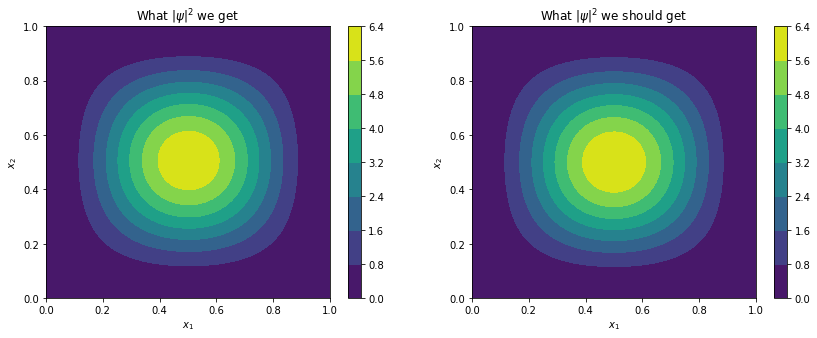


 Epoch 2
-------------------------------
Residual: 6.79319E-09, Energy: 19.72321  [  100 /  1000]
Residual: 1.09989E-08, Energy: 19.69460  [  200 /  1000]
Residual: 7.66023E-09, Energy: 19.75354  [  300 /  1000]
Residual: 7.45130E-09, Energy: 19.70572  [  400 /  1000]
Residual: 2.67152E-08, Energy: 19.71713  [  500 /  1000]
Residual: 2.07187E-08, Energy: 19.70362  [  600 /  1000]
Residual: 1.27860E-07, Energy: 19.69390  [  700 /  1000]
Residual: 6.11717E-07, Energy: 19.99356  [  800 /  1000]
Residual: 6.96834E-07, Energy: 20.20104  [  900 /  1000]
Residual: 9.57992E-07, Energy: 26.48445  [ 1000 /  1000]


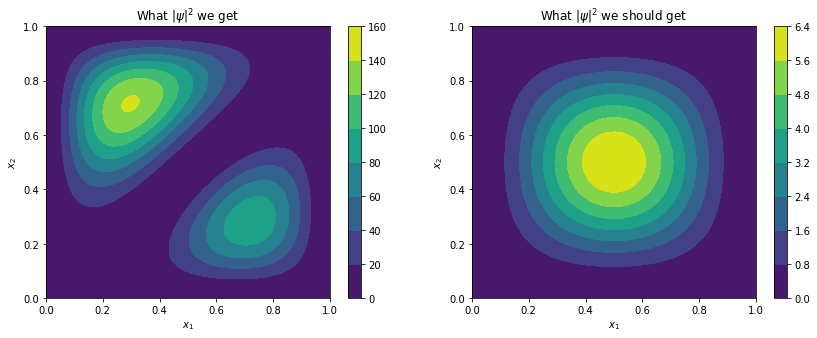


 Epoch 3
-------------------------------
Residual: 7.37498E-09, Energy: 19.91315  [  100 /  1000]
Residual: 1.75337E-09, Energy: 19.76535  [  200 /  1000]
Residual: 9.11077E-10, Energy: 19.72013  [  300 /  1000]
Residual: 6.63780E-10, Energy: 19.73999  [  400 /  1000]
Residual: 4.60453E-10, Energy: 19.71646  [  500 /  1000]
Residual: 1.87051E-10, Energy: 19.72606  [  600 /  1000]
Residual: 2.77589E-10, Energy: 19.75102  [  700 /  1000]
Residual: 1.83685E-10, Energy: 19.73141  [  800 /  1000]
Residual: 2.14301E-10, Energy: 19.71097  [  900 /  1000]
Residual: 2.00077E-10, Energy: 19.72943  [ 1000 /  1000]


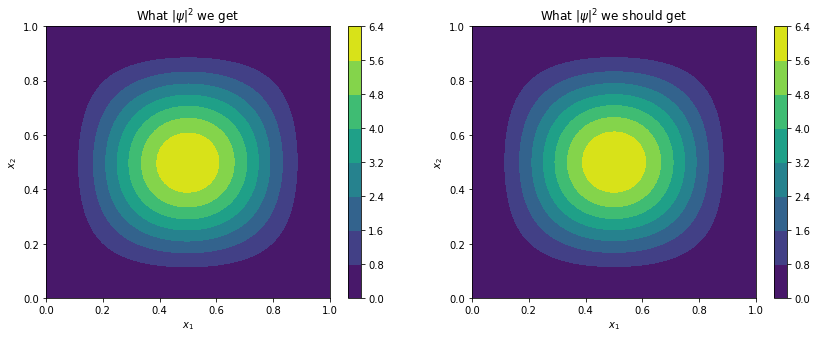


 Epoch 4
-------------------------------
Residual: 1.65248E-10, Energy: 19.78170  [  100 /  1000]
Residual: 2.58201E-10, Energy: 19.75872  [  200 /  1000]
Residual: 1.53975E-10, Energy: 19.71521  [  300 /  1000]
Residual: 1.48704E-10, Energy: 19.71940  [  400 /  1000]
Residual: 1.88786E-10, Energy: 19.69991  [  500 /  1000]
Residual: 1.39854E-10, Energy: 19.70713  [  600 /  1000]
Residual: 1.58611E-10, Energy: 19.73598  [  700 /  1000]
Residual: 1.47180E-10, Energy: 19.76527  [  800 /  1000]
Residual: 1.86551E-10, Energy: 19.73284  [  900 /  1000]
Residual: 1.27704E-10, Energy: 19.75473  [ 1000 /  1000]


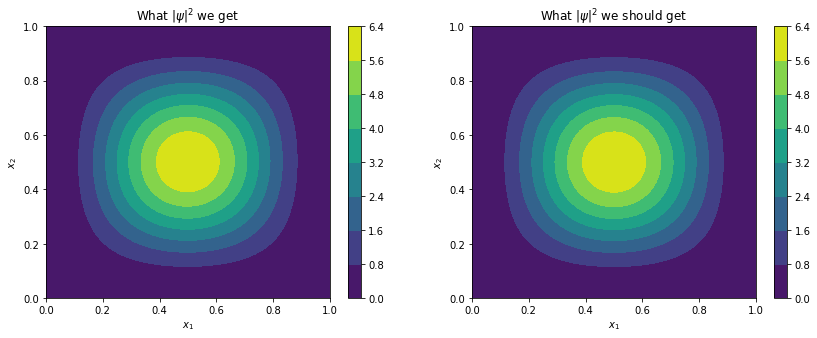


 Epoch 5
-------------------------------
Residual: 1.65721E-10, Energy: 19.73658  [  100 /  1000]
Residual: 1.59124E-10, Energy: 19.72189  [  200 /  1000]
Residual: 2.41209E-10, Energy: 19.74140  [  300 /  1000]
Residual: 1.07057E-10, Energy: 19.71883  [  400 /  1000]
Residual: 7.36195E-10, Energy: 19.70197  [  500 /  1000]
Residual: 2.25059E-10, Energy: 19.74687  [  600 /  1000]
Residual: 2.20049E-10, Energy: 19.74134  [  700 /  1000]
Residual: 2.80791E-10, Energy: 19.71916  [  800 /  1000]
Residual: 9.13393E-10, Energy: 19.73223  [  900 /  1000]
Residual: 6.70274E-08, Energy: 19.61060  [ 1000 /  1000]


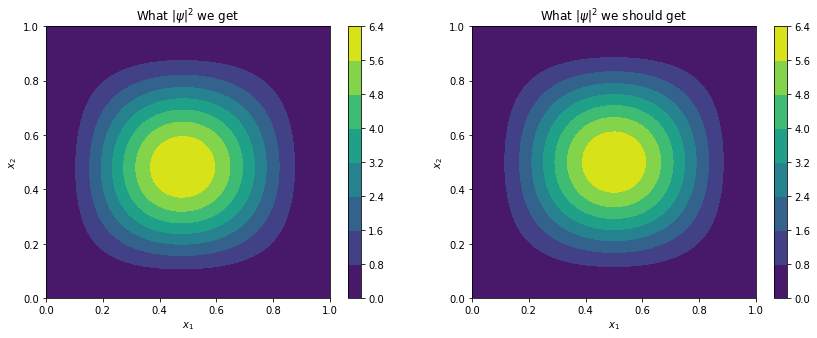


 Epoch 6
-------------------------------
Residual: 1.94204E-08, Energy: 22.68641  [  100 /  1000]
Residual: 1.99732E-10, Energy: 20.26415  [  200 /  1000]
Residual: 8.61633E-11, Energy: 20.93635  [  300 /  1000]
Residual: 3.01864E-11, Energy: 19.72216  [  400 /  1000]
Residual: 1.56025E-11, Energy: 19.91346  [  500 /  1000]
Residual: 1.54040E-11, Energy: 19.81884  [  600 /  1000]
Residual: 9.49232E-12, Energy: 19.76218  [  700 /  1000]
Residual: 8.95088E-12, Energy: 19.75696  [  800 /  1000]
Residual: 8.84263E-12, Energy: 19.75453  [  900 /  1000]
Residual: 8.08127E-12, Energy: 19.77881  [ 1000 /  1000]


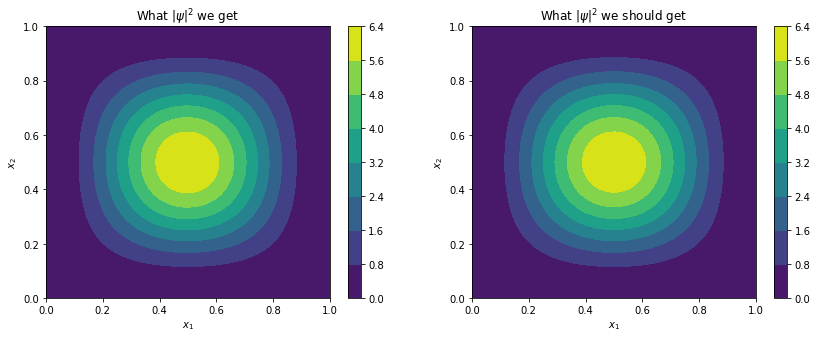


 Epoch 7
-------------------------------
Residual: 6.76507E-12, Energy: 19.77387  [  100 /  1000]
Residual: 9.03651E-12, Energy: 19.68642  [  200 /  1000]
Residual: 6.23038E-12, Energy: 19.73434  [  300 /  1000]
Residual: 1.11158E-11, Energy: 19.80048  [  400 /  1000]
Residual: 1.01165E-11, Energy: 19.82249  [  500 /  1000]
Residual: 8.28154E-12, Energy: 19.79737  [  600 /  1000]
Residual: 9.11932E-12, Energy: 19.77694  [  700 /  1000]
Residual: 1.00652E-11, Energy: 19.79817  [  800 /  1000]
Residual: 6.05250E-12, Energy: 19.78814  [  900 /  1000]
Residual: 1.03429E-11, Energy: 19.76727  [ 1000 /  1000]


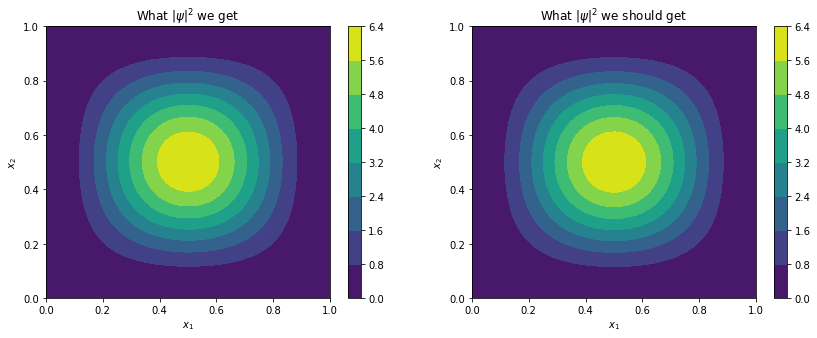


 Epoch 8
-------------------------------
Residual: 7.99913E-12, Energy: 19.75059  [  100 /  1000]
Residual: 5.43099E-12, Energy: 19.75069  [  200 /  1000]
Residual: 4.70054E-12, Energy: 19.74345  [  300 /  1000]
Residual: 7.36647E-12, Energy: 19.70837  [  400 /  1000]
Residual: 6.56451E-12, Energy: 19.74401  [  500 /  1000]
Residual: 1.46506E-11, Energy: 19.79326  [  600 /  1000]
Residual: 7.19195E-12, Energy: 19.72513  [  700 /  1000]
Residual: 4.89217E-12, Energy: 19.73512  [  800 /  1000]
Residual: 8.33840E-12, Energy: 19.75260  [  900 /  1000]
Residual: 4.67317E-12, Energy: 19.74694  [ 1000 /  1000]


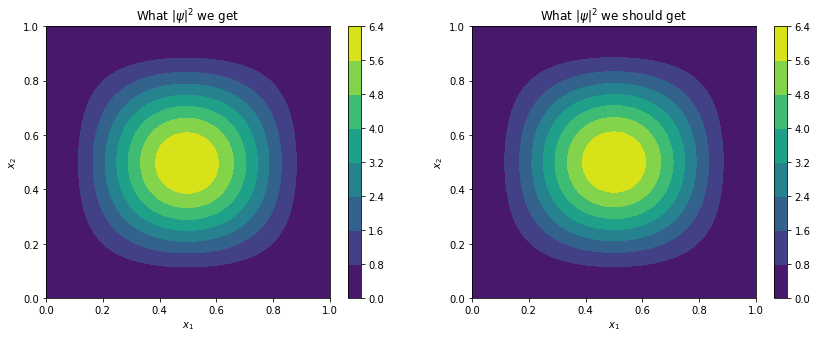


 Epoch 9
-------------------------------
Residual: 8.61788E-12, Energy: 19.73070  [  100 /  1000]
Residual: 1.25605E-11, Energy: 19.73379  [  200 /  1000]
Residual: 4.54494E-12, Energy: 19.73076  [  300 /  1000]
Residual: 3.91725E-12, Energy: 19.73979  [  400 /  1000]
Residual: 3.54402E-12, Energy: 19.75773  [  500 /  1000]
Residual: 2.17977E-11, Energy: 19.70143  [  600 /  1000]
Residual: 7.08741E-12, Energy: 19.73882  [  700 /  1000]
Residual: 5.37523E-12, Energy: 19.74950  [  800 /  1000]
Residual: 1.53622E-10, Energy: 20.07010  [  900 /  1000]
Residual: 9.45233E-08, Energy: 20.80775  [ 1000 /  1000]


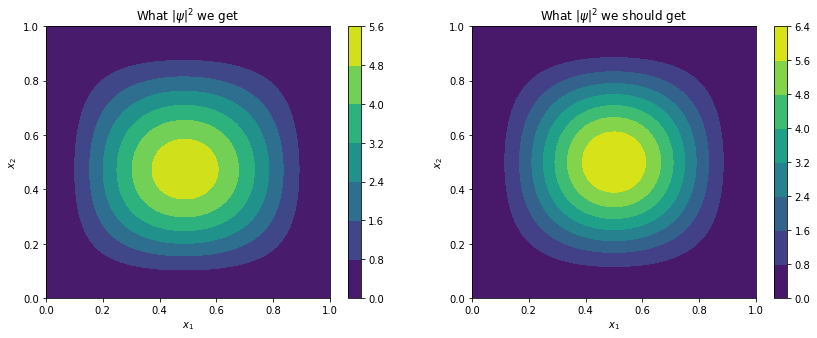


 Epoch 10
-------------------------------
Residual: 1.20957E-11, Energy: 20.00363  [  100 /  1000]
Residual: 2.28994E-12, Energy: 38.60533  [  200 /  1000]
Residual: 1.47948E-12, Energy: 19.51260  [  300 /  1000]
Residual: 1.93055E-12, Energy: 19.70814  [  400 /  1000]
Residual: 1.55212E-12, Energy: 19.70783  [  500 /  1000]
Residual: 1.45219E-12, Energy: 19.68091  [  600 /  1000]
Residual: 1.70452E-12, Energy: 19.78079  [  700 /  1000]
Residual: 1.41065E-12, Energy: 19.74927  [  800 /  1000]
Residual: 3.07096E-12, Energy: 19.78991  [  900 /  1000]
Residual: 1.47469E-12, Energy: 19.74905  [ 1000 /  1000]


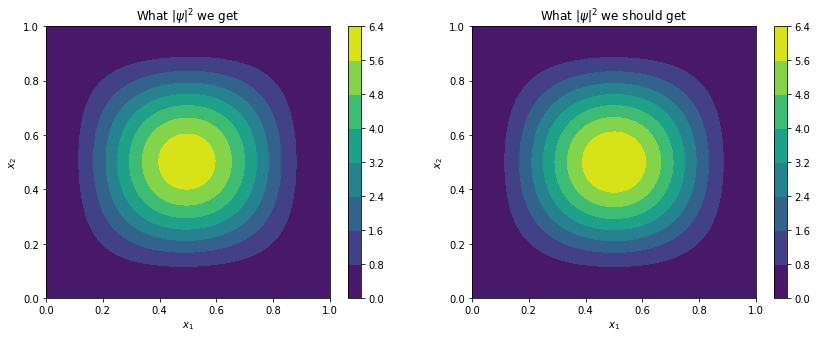


 Epoch 11
-------------------------------
Residual: 1.30170E-12, Energy: 19.81137  [  100 /  1000]
Residual: 9.05669E-13, Energy: 19.63193  [  200 /  1000]
Residual: 8.74510E-13, Energy: 19.67110  [  300 /  1000]
Residual: 8.92922E-13, Energy: 19.74660  [  400 /  1000]
Residual: 5.77952E-13, Energy: 19.76565  [  500 /  1000]
Residual: 8.31652E-13, Energy: 19.76145  [  600 /  1000]
Residual: 5.10211E-13, Energy: 19.78567  [  700 /  1000]
Residual: 4.95643E-13, Energy: 19.71738  [  800 /  1000]
Residual: 6.75203E-13, Energy: 19.82456  [  900 /  1000]
Residual: 1.10336E-12, Energy: 19.73730  [ 1000 /  1000]


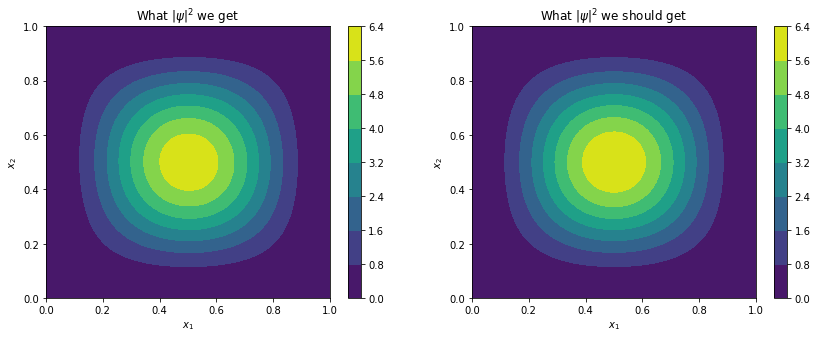


 Epoch 12
-------------------------------
Residual: 5.78935E-13, Energy: 19.83624  [  100 /  1000]
Residual: 4.80860E-13, Energy: 19.68229  [  200 /  1000]
Residual: 3.57016E-13, Energy: 19.71238  [  300 /  1000]
Residual: 3.86812E-13, Energy: 19.66095  [  400 /  1000]
Residual: 5.52955E-13, Energy: 19.88675  [  500 /  1000]
Residual: 5.79220E-13, Energy: 19.72396  [  600 /  1000]
Residual: 5.38366E-13, Energy: 19.98070  [  700 /  1000]
Residual: 3.42395E-13, Energy: 19.64559  [  800 /  1000]
Residual: 3.86018E-13, Energy: 19.92775  [  900 /  1000]
Residual: 4.10123E-13, Energy: 19.94856  [ 1000 /  1000]


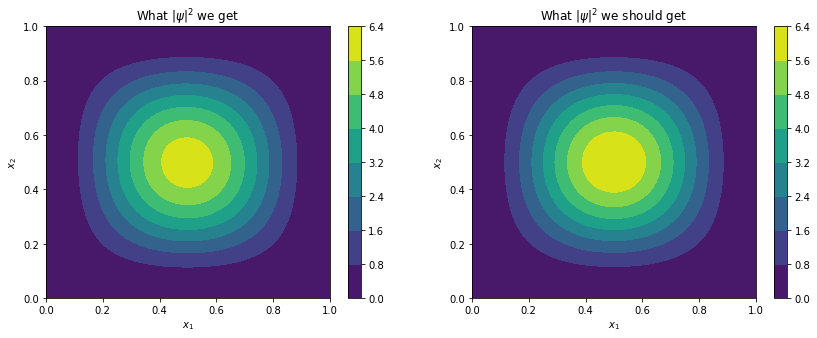


 Epoch 13
-------------------------------
Residual: 3.22872E-13, Energy: 19.70442  [  100 /  1000]
Residual: 3.23065E-13, Energy: 19.86411  [  200 /  1000]
Residual: 3.37645E-13, Energy: 19.53842  [  300 /  1000]
Residual: 2.59841E-13, Energy: 19.89782  [  400 /  1000]
Residual: 1.77794E-13, Energy: 19.84431  [  500 /  1000]
Residual: 2.24612E-13, Energy: 19.73690  [  600 /  1000]
Residual: 2.40124E-13, Energy: 19.64109  [  700 /  1000]
Residual: 4.09219E-13, Energy: 19.84003  [  800 /  1000]
Residual: 3.70665E-13, Energy: 19.87295  [  900 /  1000]
Residual: 4.79435E-13, Energy: 19.72852  [ 1000 /  1000]


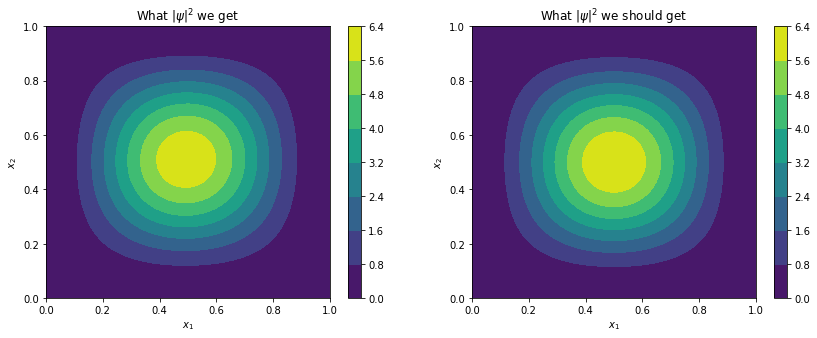


 Epoch 14
-------------------------------
Residual: 2.28156E-13, Energy: 19.65618  [  100 /  1000]
Residual: 2.85100E-13, Energy: 19.76071  [  200 /  1000]
Residual: 1.81727E-13, Energy: 19.73432  [  300 /  1000]
Residual: 2.04270E-13, Energy: 19.81142  [  400 /  1000]
Residual: 2.04616E-13, Energy: 19.78329  [  500 /  1000]
Residual: 3.18082E-12, Energy: 19.94934  [  600 /  1000]
Residual: 5.37458E-08, Energy: 19.06374  [  700 /  1000]
Residual: 9.33641E-11, Energy: 19.72646  [  800 /  1000]
Residual: 1.00140E-11, Energy: 19.74635  [  900 /  1000]
Residual: 6.13392E-12, Energy: 19.73265  [ 1000 /  1000]


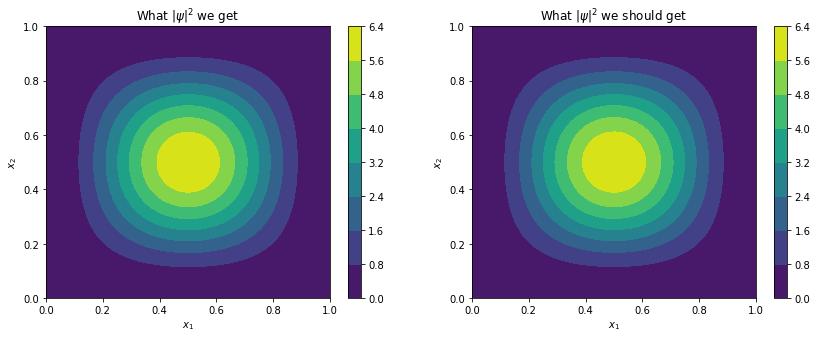


 Epoch 15
-------------------------------
Residual: 8.27454E-12, Energy: 19.74706  [  100 /  1000]
Residual: 6.24905E-12, Energy: 19.72418  [  200 /  1000]
Residual: 1.70545E-11, Energy: 19.75426  [  300 /  1000]
Residual: 2.91881E-12, Energy: 19.74027  [  400 /  1000]
Residual: 3.82900E-12, Energy: 19.79092  [  500 /  1000]
Residual: 2.53217E-12, Energy: 19.71250  [  600 /  1000]
Residual: 3.93611E-12, Energy: 19.78577  [  700 /  1000]
Residual: 3.82585E-11, Energy: 19.66089  [  800 /  1000]
Residual: 1.08333E-11, Energy: 19.71441  [  900 /  1000]
Residual: 1.58336E-07, Energy: 19.96081  [ 1000 /  1000]


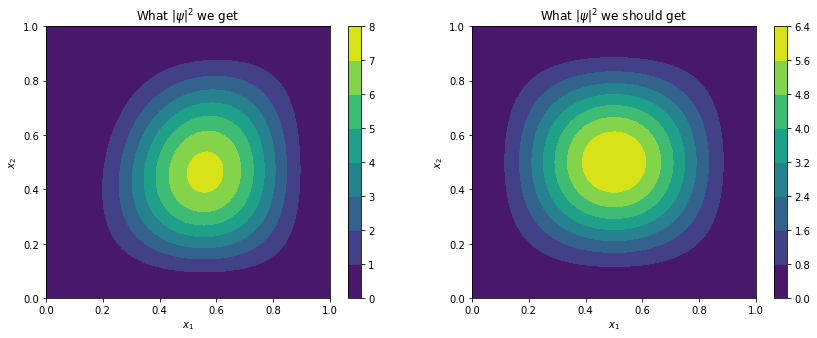


 Epoch 16
-------------------------------
Residual: 3.51990E-10, Energy: 19.74678  [  100 /  1000]
Residual: 1.67483E-10, Energy: 19.71198  [  200 /  1000]
Residual: 9.43769E-11, Energy: 19.74572  [  300 /  1000]
Residual: 9.91391E-11, Energy: 19.71337  [  400 /  1000]
Residual: 5.92192E-11, Energy: 19.72971  [  500 /  1000]
Residual: 3.14420E-11, Energy: 19.73142  [  600 /  1000]
Residual: 3.73018E-11, Energy: 19.72636  [  700 /  1000]
Residual: 1.84799E-11, Energy: 19.74687  [  800 /  1000]
Residual: 1.45300E-11, Energy: 19.74376  [  900 /  1000]
Residual: 1.08850E-11, Energy: 19.74965  [ 1000 /  1000]


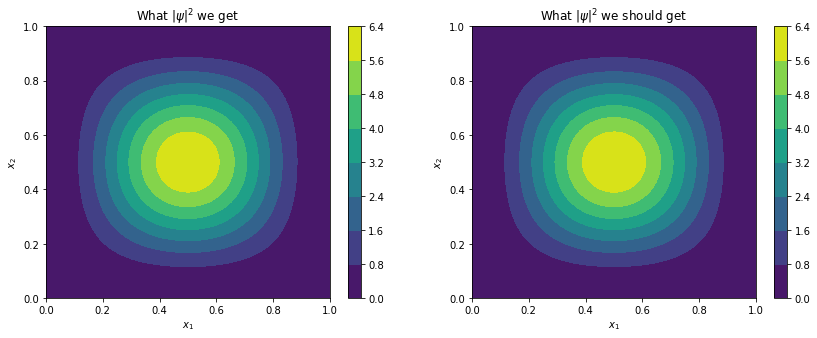


 Epoch 17
-------------------------------
Residual: 1.31800E-11, Energy: 19.73313  [  100 /  1000]
Residual: 5.44231E-12, Energy: 19.74118  [  200 /  1000]
Residual: 5.22697E-12, Energy: 19.73779  [  300 /  1000]
Residual: 4.07417E-12, Energy: 19.73028  [  400 /  1000]
Residual: 5.16608E-12, Energy: 19.73796  [  500 /  1000]
Residual: 4.42116E-12, Energy: 19.75445  [  600 /  1000]
Residual: 2.11728E-12, Energy: 19.74017  [  700 /  1000]
Residual: 2.69455E-12, Energy: 19.73971  [  800 /  1000]
Residual: 2.40224E-12, Energy: 19.73481  [  900 /  1000]
Residual: 1.82475E-12, Energy: 19.74850  [ 1000 /  1000]


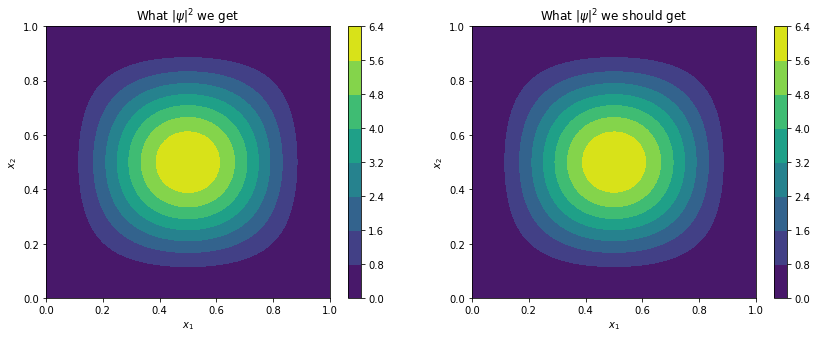


 Epoch 18
-------------------------------
Residual: 1.71085E-12, Energy: 19.74509  [  100 /  1000]
Residual: 1.62036E-12, Energy: 19.74780  [  200 /  1000]
Residual: 9.92984E-13, Energy: 19.74081  [  300 /  1000]
Residual: 1.94407E-12, Energy: 19.72691  [  400 /  1000]
Residual: 2.04304E-12, Energy: 19.73574  [  500 /  1000]
Residual: 1.10546E-12, Energy: 19.74361  [  600 /  1000]
Residual: 1.79617E-12, Energy: 19.73332  [  700 /  1000]
Residual: 7.52513E-13, Energy: 19.73949  [  800 /  1000]
Residual: 3.94407E-13, Energy: 19.74450  [  900 /  1000]
Residual: 1.24114E-12, Energy: 19.74579  [ 1000 /  1000]


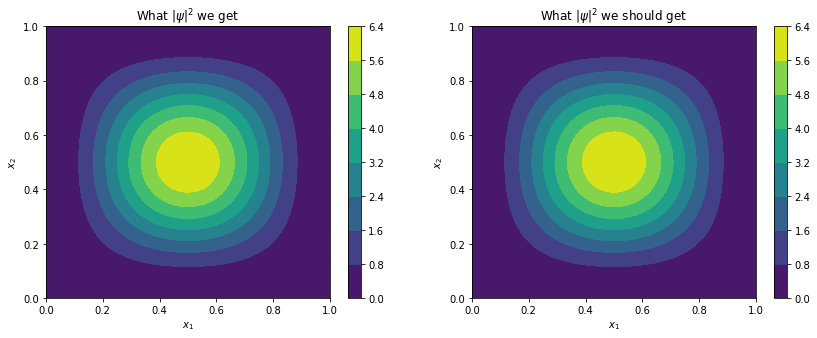


 Epoch 19
-------------------------------
Residual: 4.61688E-13, Energy: 19.74183  [  100 /  1000]
Residual: 3.15957E-13, Energy: 19.73869  [  200 /  1000]
Residual: 7.12068E-13, Energy: 19.73527  [  300 /  1000]
Residual: 2.68014E-13, Energy: 19.74010  [  400 /  1000]
Residual: 8.21120E-13, Energy: 19.74434  [  500 /  1000]
Residual: 2.19550E-13, Energy: 19.74315  [  600 /  1000]
Residual: 8.33771E-13, Energy: 19.74837  [  700 /  1000]
Residual: 2.18168E-13, Energy: 19.74235  [  800 /  1000]
Residual: 1.21448E-13, Energy: 19.74306  [  900 /  1000]
Residual: 1.21750E-13, Energy: 19.74198  [ 1000 /  1000]


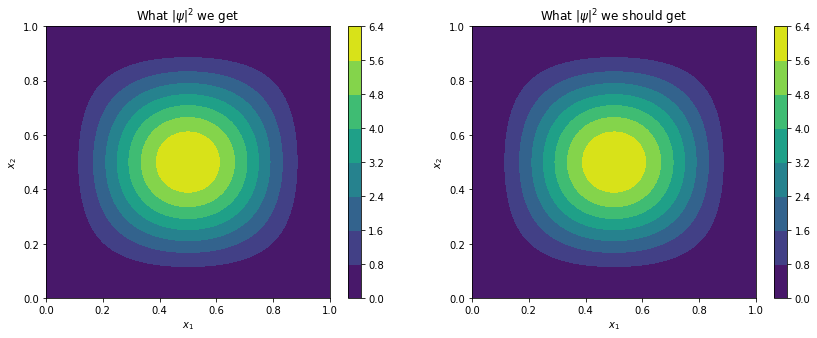


 Epoch 20
-------------------------------
Residual: 1.63565E-13, Energy: 19.74022  [  100 /  1000]
Residual: 4.84870E-12, Energy: 19.75979  [  200 /  1000]
Residual: 1.50839E-13, Energy: 19.74264  [  300 /  1000]
Residual: 4.57994E-13, Energy: 19.73347  [  400 /  1000]
Residual: 5.39178E-13, Energy: 19.73811  [  500 /  1000]
Residual: 1.08364E-11, Energy: 19.74400  [  600 /  1000]
Residual: 2.53677E-10, Energy: 19.81595  [  700 /  1000]
Residual: 3.30542E-10, Energy: 19.71929  [  800 /  1000]
Residual: 5.15593E-12, Energy: 19.73626  [  900 /  1000]
Residual: 2.91598E-12, Energy: 19.78156  [ 1000 /  1000]


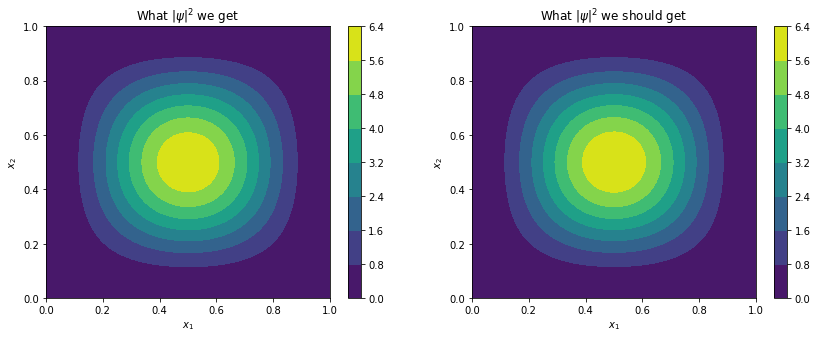


 Epoch 21
-------------------------------
Residual: 3.20259E-12, Energy: 19.75657  [  100 /  1000]
Residual: 2.74102E-12, Energy: 19.74141  [  200 /  1000]
Residual: 1.58785E-12, Energy: 19.75201  [  300 /  1000]
Residual: 1.11404E-12, Energy: 19.73902  [  400 /  1000]
Residual: 1.23101E-12, Energy: 19.75594  [  500 /  1000]
Residual: 5.90015E-13, Energy: 19.75957  [  600 /  1000]
Residual: 1.08116E-12, Energy: 19.73712  [  700 /  1000]
Residual: 6.03326E-13, Energy: 19.72650  [  800 /  1000]
Residual: 9.48900E-13, Energy: 19.74838  [  900 /  1000]
Residual: 4.66024E-13, Energy: 19.76119  [ 1000 /  1000]


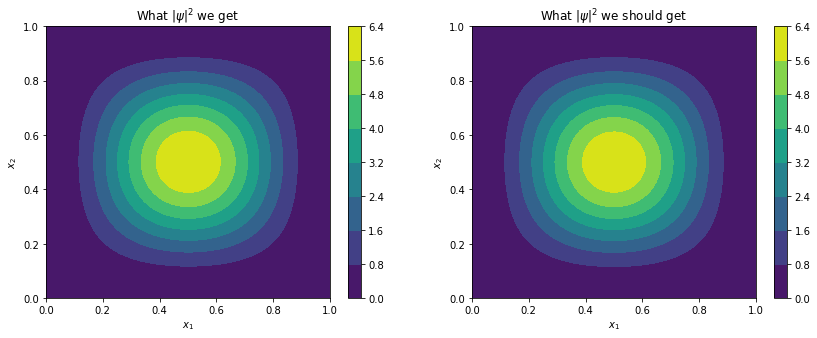


 Epoch 22
-------------------------------
Residual: 3.25348E-13, Energy: 19.75599  [  100 /  1000]
Residual: 3.71485E-13, Energy: 19.71977  [  200 /  1000]
Residual: 1.25082E-13, Energy: 19.72327  [  300 /  1000]
Residual: 3.88335E-13, Energy: 19.67606  [  400 /  1000]
Residual: 1.10283E-13, Energy: 19.74962  [  500 /  1000]
Residual: 1.17991E-13, Energy: 19.79681  [  600 /  1000]
Residual: 2.35412E-13, Energy: 19.71657  [  700 /  1000]
Residual: 8.80840E-14, Energy: 19.76392  [  800 /  1000]
Residual: 1.07966E-13, Energy: 19.61756  [  900 /  1000]
Residual: 2.04941E-13, Energy: 19.79084  [ 1000 /  1000]


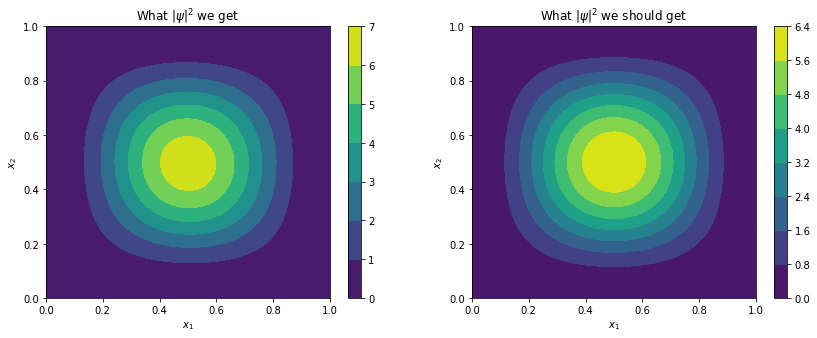


 Epoch 23
-------------------------------
Residual: 4.52299E-14, Energy: 19.87645  [  100 /  1000]
Residual: 1.67082E-13, Energy: 19.74633  [  200 /  1000]
Residual: 6.39070E-14, Energy: 19.82371  [  300 /  1000]
Residual: 5.24979E-13, Energy: 19.70427  [  400 /  1000]
Residual: 1.04962E-09, Energy: 20.01256  [  500 /  1000]
Residual: 3.99732E-12, Energy: 19.76062  [  600 /  1000]
Residual: 1.59961E-12, Energy: 19.73351  [  700 /  1000]
Residual: 2.27697E-12, Energy: 19.74208  [  800 /  1000]
Residual: 2.78584E-12, Energy: 19.76061  [  900 /  1000]
Residual: 7.72571E-13, Energy: 19.76310  [ 1000 /  1000]


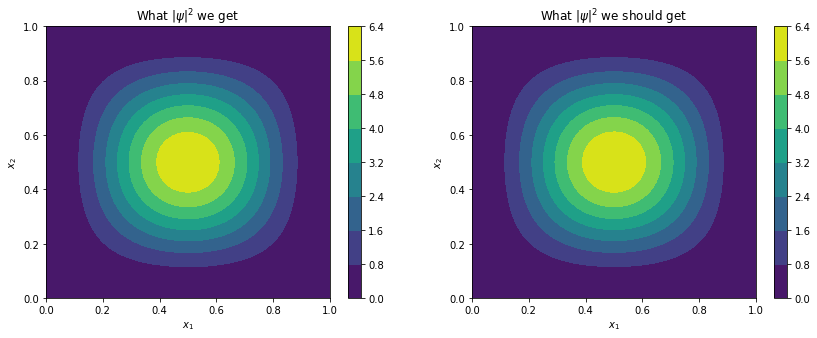


 Epoch 24
-------------------------------
Residual: 8.15871E-13, Energy: 19.72228  [  100 /  1000]
Residual: 7.91911E-13, Energy: 19.77881  [  200 /  1000]
Residual: 2.68048E-13, Energy: 19.75324  [  300 /  1000]
Residual: 2.47140E-13, Energy: 19.71511  [  400 /  1000]
Residual: 2.15317E-12, Energy: 19.71812  [  500 /  1000]
Residual: 1.44980E-12, Energy: 19.79064  [  600 /  1000]
Residual: 1.29817E-11, Energy: 19.79496  [  700 /  1000]
Residual: 1.05694E-09, Energy: 19.73820  [  800 /  1000]
Residual: 9.70342E-11, Energy: 19.73652  [  900 /  1000]
Residual: 7.00319E-11, Energy: 19.72659  [ 1000 /  1000]


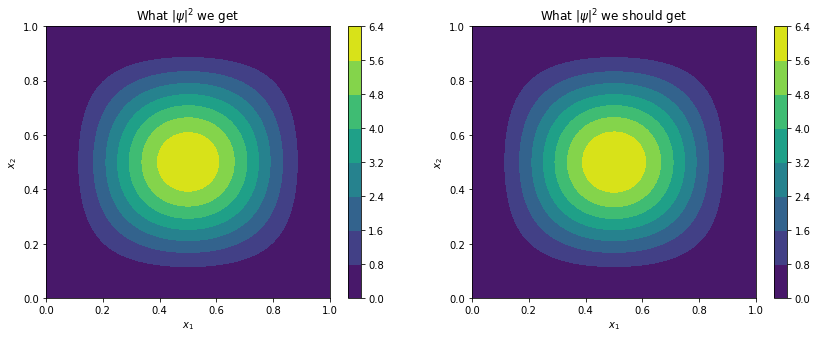


 Epoch 25
-------------------------------
Residual: 3.68628E-11, Energy: 19.73825  [  100 /  1000]
Residual: 1.95981E-11, Energy: 19.75435  [  200 /  1000]
Residual: 2.88830E-11, Energy: 19.74927  [  300 /  1000]
Residual: 1.32243E-11, Energy: 19.73931  [  400 /  1000]
Residual: 8.75632E-12, Energy: 19.73847  [  500 /  1000]
Residual: 7.63325E-12, Energy: 19.75649  [  600 /  1000]
Residual: 5.52087E-12, Energy: 19.74088  [  700 /  1000]
Residual: 4.19143E-12, Energy: 19.72642  [  800 /  1000]
Residual: 3.05367E-12, Energy: 19.74686  [  900 /  1000]
Residual: 5.68338E-12, Energy: 19.75683  [ 1000 /  1000]


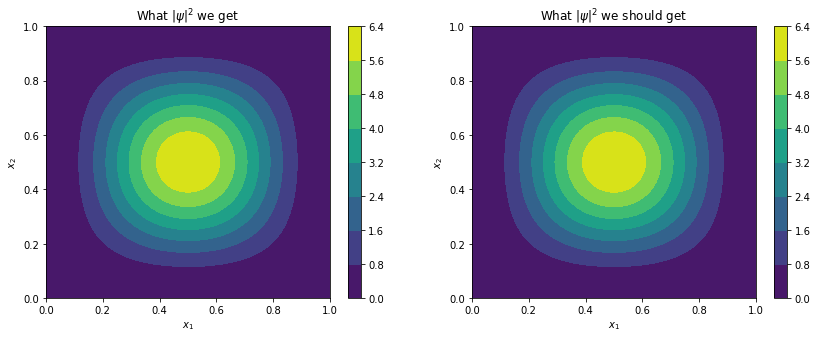

In [44]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 25
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)
  scheduler.step()
  plot_compare_2d(wf)

# 3D

In [62]:
N = 3
wf = WaveFunction(N, [100]*4).to(device)

In [63]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 3
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 100, 1000, wf, optimizer)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 4.55860E-09, Energy: 29.55577  [  100 /  1000]
Residual: 7.23107E-10, Energy: 29.57156  [  200 /  1000]
Residual: 4.43606E-10, Energy: 29.74988  [  300 /  1000]
Residual: 3.39651E-10, Energy: 29.46626  [  400 /  1000]
Residual: 3.22083E-10, Energy: 29.68493  [  500 /  1000]
Residual: 2.57660E-10, Energy: 29.61972  [  600 /  1000]
Residual: 1.62936E-10, Energy: 29.65004  [  700 /  1000]
Residual: 1.97915E-10, Energy: 29.54120  [  800 /  1000]
Residual: 1.85122E-10, Energy: 29.65845  [  900 /  1000]
Residual: 2.03499E-10, Energy: 29.73078  [ 1000 /  1000]

 Epoch 2
-------------------------------
Residual: 2.34295E-10, Energy: 29.74549  [  100 /  1000]
Residual: 1.03584E-10, Energy: 29.58171  [  200 /  1000]
Residual: 2.03832E-10, Energy: 29.78849  [  300 /  1000]
Residual: 1.05205E-10, Energy: 29.68241  [  400 /  1000]
Residual: 9.08270E-11, Energy: 29.59899  [  500 /  1000]
Residual: 7.31093E-11, Energy: 29.55000  [  600 /  1000]
Resi

# ND

In [85]:
N = 8
wf = WaveFunction(N, [100]*4).to(device)

In [86]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 200, 1000, wf, optimizer)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 5.92898E-13, Energy: 80.15005  [  100 /  1000]
Residual: 7.98318E-13, Energy: 80.90271  [  200 /  1000]
Residual: 4.43088E-13, Energy: 84.07256  [  300 /  1000]
Residual: 4.15674E-13, Energy: 86.93941  [  400 /  1000]
Residual: 4.66843E-13, Energy: 78.85416  [  500 /  1000]
Residual: 2.67802E-13, Energy: 95.42710  [  600 /  1000]


KeyboardInterrupt: ignored